In [28]:
import numpy as np
import pandas as pd
from keras.utils import np_utils
np.random.seed(10)
from keras.datasets import mnist
(X_train_image, y_train_label),\
(X_test_image, y_test_label) = mnist.load_data()
x_Train = X_train_image.reshape(60000,784).astype('float32')
x_Test = X_test_image.reshape(10000,784).astype('float32')
x_Train_normalized = x_Train/225
x_Test_normalized = x_Test/225
y_TrainOneHot = np_utils.to_categorical(y_train_label)
y_TestOneHot = np_utils.to_categorical(y_test_label)

In [18]:
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(5,5)
    plt.imshow(image,cmap='binary')
    plt.show()

In [32]:
import numpy as np
import copy
import math
class CNN:
    def __init__(self,layers,Clayers):
        self.layers = layers
        self.convolution = 1
        self.nums = len(layers)
        self.result = []
        self.weight = [np.random.randn(x,y) for x,y in zip(layers[1:],layers)]
        self.bias = [np.random.randn(p) for p in layers[1:]]
        self.loss = []
        self.data_a = [np.ones((x)) for x in layers]
        self.data_z = [np.ones((x)) for x in layers[1:]]
        self.kernel = [np.random.randn(x,y,3,3) for x,y in zip(Clayers[1:],Clayers)]
        self.convol_bias = [np.zeros((x)) for x in Clayers[1:]]
        self.data_convol = []
        self.data_convol_z = []
        self.data_pooling = []
    def feedforward(self):
        self.data_a[0] = np.array(self.data_pooling[len(self.data_pooling)-1])
        temp_reform = (self.data_a[0].shape)
        self.data_a[0] = self.data_a[0].reshape(temp_reform[0]*temp_reform[1]*temp_reform[2])
        for i in range (self.nums-1): 
            z = np.matmul(self.weight[i],self.data_a[i])
            z += self.bias[i]
            temp = copy.copy(z)
            self.data_z[i] = temp
            #z = ReLU_FC(z)
            z = sigmoid(z)
            self.data_a[i+1] = z
        self.result = self.data_a[self.nums-1]
    def backpropagation(self,correction,learning_rate):
        C0_deri = (self.result-correction)*2
        C0_deri = np.array(C0_deri)
        self.loss.append(np.sum(np.square(self.result-correction)))
        for i in range(self.nums-2,-1,-1):
            #sigmoid = np.array(ReLU_deri_FC(self.data_z[i]),dtype='float64')
            sigmoid = np.array(sigmoid_der(self.data_z[i]),dtype='float64')
            sigmoid = sigmoid*C0_deri
            temp = np.array([sigmoid])
            C0_deri = np.matmul(self.weight[i].T,sigmoid)
            weight = np.matmul(np.transpose(temp),np.array([self.data_a[i]]))
            self.learning(i,np.array(weight),np.array(sigmoid),learning_rate,correction)
        self.backprop_nonFC(C0_deri.reshape(12,13,13),self.convolution-1,learning_rate)
    def convolutionLayer(self,input_):
        self.data_pooling.append([input_])
        for i in range(self.convolution):
            output = np.zeros((int(len(self.kernel[i])),len(self.data_pooling[i][0])-2,len(self.data_pooling[i][0])-2))
            for j in range(len(self.kernel[i])):
                sum = np.zeros((len(self.data_pooling[i][0])-2,len(self.data_pooling[i][0])-2))
                for k in range(len(self.kernel[i][0])):
                    sum+=convolute(self.data_pooling[i][k],self.kernel[i][j][k])
                output[j]=sum+self.convol_bias[i][j]
            self.data_convol_z.append(copy.copy(output))
            temp = sigmoid(output)
            #temp = ReLU(output)
            self.data_pooling.append(average_pooling(temp))
    def backprop_nonFC(self,input_deri,position,learning_rate):
        if(position<0):
            self.data_convol.clear()
            self.data_convol_z.clear()
            self.data_pooling.clear()
            return 0
        C0_deri = []
        for j in range (len(input_deri)):
            C0_deri.append(backprop_pooling(input_deri[j]))
        #C0_F = C0_deri*ReLU_deri(self.data_convol_z[position])
        C0_F = C0_deri*sigmoid_der(self.data_convol_z[position])
        bias_deri = []
        for i in range(len(C0_F)):
            bias_deri.append(np.sum(C0_F[i]))
        self.learningBias(position,bias_deri,learning_rate)
        for i in range(len(C0_F)):
            for j in range(len(self.data_pooling[position])):
                C0_k = convolute(self.data_pooling[position][j],C0_F[i])
                self.learningConvol(position,i,j,C0_k,learning_rate)
        C0_next=[]
        for i in range(len(self.data_pooling[position])):
            sum = np.zeros((len(self.data_pooling[position][0]),len(self.data_pooling[position][0])))
            for j in range(len(self.kernel[position])):
                sum+=full_convolute(self.kernel[position][j][i],C0_F[j])
            C0_next.append(sum)
        self.backprop_nonFC(C0_next,position-1,learning_rate)
    def learning(self,i,weight,bias,learning_rate,correction):
        n = -1*learning_rate
        delta_bias = n*bias
        delta_weight = n*weight
        self.weight[i]+=delta_weight
        self.bias[i]+=delta_bias
    def learningConvol(self,i,j,k,kernel,learning_rate):
        print(kernel)
        n = -1*learning_rate
        delta_kernel = n*kernel
        self.kernel[i][j][k] += delta_kernel
    def learningBias(self,i,bias_deri,learning_rate):
        n = -1*learning_rate
        delta_kernel = np.array(bias_deri)
        delta_kernel = delta_kernel*n
        self.convol_bias[i]+=delta_kernel
def average_pooling(a):
    output = []
    for i in range(len(a)):
        s = np.zeros((int(len(a[i])/2),int(len(a[i])/2)))
        for j in range(len(a[i])):
            for k in range(len(a[i])):
                s[int(j/2),int(k/2)]+=a[i][j][k]/4
        output.append(s)
    return output
def backprop_pooling(C0):
    output = np.zeros((len(C0)*2,len(C0)*2))
    for i in range(len(C0)*2):
        for j in range(len(C0)*2):
            output[i][j] = C0[int(i/2)][int(j/2)]*1/4
    return output
def convolute(a,b):
    output = []
    for i in range(len(a)-len(b)+1):
        temp = []
        for j in range(len(a[0])-len(b)+1):
            sum_ = 0
            for k in range(len(b)):                    
                sum_ += np.dot(a[i+k][j:j+len(b[k])],b[k])
            temp.append(sum_)
        output.append(temp)
    return np.array(output)
def full_convolute(a,b):
    rotate = np.zeros((len(b),len(b)))
    for i in range(len(b)):
        rotate[i][len(b)-i-1] = 1
    b = np.matmul(rotate,b)
    wrap = np.pad(a, len(b)-1, pad_with)
    return convolute(wrap,b)
def sigmoid(z):
    return 1.0/(1.0+np.exp(-1*z))
def sigmoid_der(z):
    a = sigmoid(z)
    return a*(1-a)
def ReLU(z):
    for k in range(len(z)):
        for i in range(len(z[0])):
            for j in range(len(z[0][0])):
                if(z[k][i][j]<0):
                    z[k][i][j]=max(0,z[k][i][j])
    return z
def ReLU_deri(z):
    output = np.zeros((len(z),len(z[0]),len(z[0][0])))
    for k in range(len(z)):
        for i in range(len(z[0])):
            for j in range(len(z[0][0])):
                if(z[k][i][j]>=0):
                    output[k][i][j] = 1
                else:
                    output[k][i][j] = 0
    return output
def ReLU_FC(z):
    c = np.zeros((len(z)))
    for i in range(len(z)):
        if(z[i]<0):
            c[i]=z[i]*0.01
        else:
            c[i]=z[i]
    return c
def ReLU_deri_FC(z):
    c = np.zeros((len(z)))
    for i in range(len(z)):
        if(z[i]>0):
            c[i] = 1
        else:
            c[i] = 0.01
    return c
def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
network = CNN([2028,400,10],[1,12])

In [33]:
import matplotlib.pyplot as plt
a = []
b = []
network.loss.clear()
for p in range(30):
    b.append(p)
    sum_value = 0
    for i in range (100):
        network.convolutionLayer(x_Train_normalized[100*p+i].reshape(28,28))
        network.feedforward()
        index = np.argmax(network.result)
        if(index==y_train_label[100*p+i]):
            sum_value+=1     
        network.backpropagation(y_TrainOneHot[100*p+i],0.25)
    print("epoch ",p+1)
    print(sum_value,"/100")
    print("accuracy",sum_value,"%")
    a.append(np.sum(network.loss))
    network.loss.clear()
    sum_value=0
    for i in range(100):
        network.convolutionLayer(x_Test_normalized[i].reshape(28,28))
        network.feedforward()
        index = np.argmax(network.result)
        if(index==y_test_label[i]):
            sum_value+=1   
    print(sum_value,"/100")
    print("accuracy",sum_value,"%")
plt.plot(b,a)

[[ 3.48519894e-03  2.84070825e-05 -4.73282172e-03]
 [ 5.03541415e-03  9.87299429e-04  2.59132098e-03]
 [ 3.84920412e-03 -1.34619947e-05 -5.08569463e-04]]
[[-0.0135575  -0.01417327 -0.01254205]
 [-0.00906554 -0.00645647 -0.00059073]
 [-0.01290805 -0.00968492 -0.00243352]]
[[-0.02243786 -0.02732853 -0.02300903]
 [ 0.01134365  0.00136452 -0.00387734]
 [ 0.02198833  0.0176738   0.0081893 ]]
[[0.00926843 0.00999989 0.01574685]
 [0.01268767 0.00922671 0.01373341]
 [0.03276908 0.02127432 0.01275529]]
[[-0.03684431 -0.04220379 -0.03772797]
 [-0.02966347 -0.04127534 -0.04781981]
 [-0.01807456 -0.02589109 -0.03788365]]
[[0.0293525  0.01767213 0.00339542]
 [0.02424478 0.0106031  0.00025232]
 [0.01254343 0.00706975 0.00594994]]
[[ 0.01136404 -0.00074197 -0.00778393]
 [ 0.01215038  0.00321234 -0.00307682]
 [ 0.0119092   0.00459066  0.0029472 ]]
[[0.04958758 0.03960664 0.03647896]
 [0.0326163  0.02640809 0.03271495]
 [0.02069423 0.01198621 0.01785151]]
[[ 0.02278535  0.03670108  0.04968309]
 [ 0.002

[[-0.02940905 -0.06063979 -0.09380095]
 [-0.03886194 -0.04509056 -0.0610492 ]
 [-0.04849612 -0.03661648 -0.04470577]]
[[-0.10183571 -0.1710532  -0.1863577 ]
 [-0.07766463 -0.17918371 -0.21370438]
 [-0.04248228 -0.19111131 -0.24018013]]
[[0.09329591 0.11722862 0.12916122]
 [0.12589952 0.16440701 0.13819334]
 [0.12177841 0.1756484  0.13324232]]
[[0.06795786 0.04094331 0.14523579]
 [0.05848594 0.03107878 0.09786888]
 [0.04889977 0.01540182 0.04758739]]
[[0.03557472 0.05417253 0.13858702]
 [0.02712007 0.03360886 0.12190216]
 [0.000705   0.00946485 0.09750993]]
[[-0.00015654 -0.01791081 -0.07000774]
 [ 0.04747016  0.05080286 -0.00023261]
 [ 0.06785562  0.09007867  0.01490619]]
[[-0.02123098 -0.01027917 -0.01411025]
 [-0.01577309 -0.01171758 -0.00071617]
 [-0.01305525 -0.00656385  0.01356743]]
[[0.00380268 0.03294114 0.08461615]
 [0.01264996 0.03236024 0.09712971]
 [0.02910377 0.02746898 0.09486618]]
[[ 0.06486968  0.09114503  0.02642491]
 [ 0.05655211  0.06949588 -0.0145629 ]
 [ 0.05999932 

KeyboardInterrupt: 

[[-0.05770891  0.04493798  0.04922538]
 [ 0.05997113  0.21010181  0.3064357 ]
 [ 0.28796598  0.41170675  0.50463586]]
[[0.2344097  0.35236411 0.40747974]
 [0.20990881 0.27807818 0.21892157]
 [0.12693039 0.25381272 0.26378713]]
[[ 0.06501427  0.02230874 -0.0782568 ]
 [ 0.08905984  0.02873305 -0.01347409]
 [ 0.03479874  0.0060464   0.0406654 ]]
[[-0.19911461 -0.07999351 -0.02597529]
 [-0.19717896 -0.09715156  0.05376738]
 [-0.17760936 -0.08471733  0.01465431]]
[[ 0.01819138  0.001636   -0.06256358]
 [ 0.0447645   0.04496688 -0.04899623]
 [ 0.05370545  0.02586564 -0.1305188 ]]
[[-0.25039405 -0.30870355 -0.36357387]
 [-0.32839586 -0.3226889  -0.28447232]
 [-0.26841636 -0.27400424 -0.2756868 ]]
[[-0.02638319 -0.00871637 -0.06015038]
 [ 0.11739881  0.12258261  0.08047815]
 [ 0.16331078  0.18940758  0.21422349]]
[[ 0.06433335  0.06448486 -0.12916767]
 [ 0.08175536  0.02337593 -0.19032675]
 [-0.21330067 -0.2699907  -0.32537925]]
[[0.3628921  0.36585907 0.1957782 ]
 [0.50773962 0.58638708 0.488

[[-8.21808047e-05 -7.57868723e-05 -1.44950186e-04]
 [ 5.25599688e-05 -5.05368298e-05 -6.51236752e-05]
 [ 2.32527753e-04  2.22272438e-04  2.51070563e-04]]
[[-1.79611891e-04  3.84544232e-05  2.31003848e-04]
 [-3.33460668e-04 -1.40954826e-04  2.96953195e-05]
 [-6.06756077e-05 -6.79618254e-05  2.62351589e-06]]
[[ 4.34049761e-04  4.22748239e-04  3.07858513e-04]
 [ 2.20721093e-04  1.05783603e-04 -3.48227980e-05]
 [ 1.79356087e-05  1.65321325e-05 -2.43208890e-05]]
[[0.00025112 0.00037327 0.00061289]
 [0.00030941 0.00035299 0.00071368]
 [0.00032932 0.00037247 0.000697  ]]
[[-3.72417581e-04 -2.16865979e-04 -1.52333739e-05]
 [-3.06900830e-04 -2.25894232e-04  7.32571691e-06]
 [-1.76062219e-04 -2.73602336e-04 -1.93699057e-04]]
[[-0.00040174 -0.00013901  0.00020254]
 [-0.00036789 -0.00012197  0.00021915]
 [-0.00022064 -0.00022081 -0.00014353]]
[[ 1.20490362e-04  1.71986783e-04  1.94073318e-04]
 [ 1.78029569e-05  1.55457955e-04  1.98838234e-04]
 [-2.39365201e-04 -1.38952904e-04 -5.36514267e-05]]
[[0

[[-5.23678974e-05 -5.02037463e-05 -1.00785793e-04]
 [ 2.72024774e-05 -4.09320726e-05 -5.47585129e-05]
 [ 1.39421213e-04  1.24417436e-04  1.41575081e-04]]
[[-9.22962368e-05  3.78799320e-05  1.54900903e-04]
 [-1.98003095e-04 -8.23599693e-05  2.43359231e-05]
 [-3.11735112e-05 -3.56168985e-05  7.62736876e-06]]
[[ 2.58528030e-04  2.46477958e-04  1.71581001e-04]
 [ 1.24057016e-04  5.63471805e-05 -3.01615416e-05]
 [ 3.67566367e-06  5.91854464e-06 -1.80419984e-05]]
[[0.00014976 0.00021446 0.00035086]
 [0.00019128 0.00021137 0.00041754]
 [0.00019409 0.00022275 0.00041142]]
[[-2.18307430e-04 -1.22668385e-04 -1.26041568e-06]
 [-1.80079000e-04 -1.29291633e-04  1.21327297e-05]
 [-1.02614278e-04 -1.57308079e-04 -1.02095427e-04]]
[[-2.45119867e-04 -8.66139594e-05  1.23629676e-04]
 [-2.23364699e-04 -7.94597288e-05  1.29999513e-04]
 [-1.31925919e-04 -1.31315462e-04 -7.70167240e-05]]
[[ 6.78292702e-05  9.86924766e-05  1.10318924e-04]
 [ 9.81342442e-06  8.69439164e-05  1.08603250e-04]
 [-1.54720997e-04 -

[[-3.92958623e-05 -3.90319964e-05 -8.02866019e-05]
 [ 1.72352496e-05 -3.54028572e-05 -4.84286237e-05]
 [ 1.00087126e-04  8.46255375e-05  9.63611510e-05]]
[[-5.92092827e-05  3.42246145e-05  1.19437049e-04]
 [-1.41722076e-04 -5.81603460e-05  2.09527502e-05]
 [-1.97732345e-05 -2.27588534e-05  8.90927819e-06]]
[[ 1.85127199e-04  1.74144664e-04  1.17547891e-04]
 [ 8.53480255e-05  3.72271909e-05 -2.60246908e-05]
 [-4.76028435e-07  2.54293433e-06 -1.44682443e-05]]
[[0.00010731 0.00014991 0.00024455]
 [0.00014081 0.00015268 0.00029657]
 [0.00013911 0.00016098 0.00029419]]
[[-1.54560476e-04 -8.44358753e-05  2.94854429e-06]
 [-1.27501429e-04 -8.95177197e-05  1.28581738e-05]
 [-7.26027597e-05 -1.09888403e-04 -6.65127668e-05]]
[[-1.78520075e-04 -6.37826720e-05  9.07746241e-05]
 [-1.61928253e-04 -6.00868937e-05  9.31608077e-05]
 [-9.43700950e-05 -9.33508191e-05 -5.02625819e-05]]
[[ 4.70933592e-05  6.90984228e-05  7.63129198e-05]
 [ 6.56036327e-06  5.94402855e-05  7.29303916e-05]
 [-1.17275301e-04 -

[[-3.17434471e-05 -3.24608780e-05 -6.77479317e-05]
 [ 1.21090266e-05 -3.13927042e-05 -4.35912299e-05]
 [ 7.83060017e-05  6.33670161e-05  7.20129425e-05]]
[[-4.21424334e-05  3.08604348e-05  9.82539559e-05]
 [-1.10516927e-04 -4.48623614e-05  1.85072971e-05]
 [-1.38629197e-05 -1.60170107e-05  9.15748908e-06]]
[[ 1.44519821e-04  1.34607915e-04  8.87261801e-05]
 [ 6.46080040e-05  2.72627997e-05 -2.28669300e-05]
 [-2.08996906e-06  1.05157843e-06 -1.21435316e-05]]
[[8.38760448e-05 1.14997943e-04 1.87079863e-04]
 [1.12385559e-04 1.20252553e-04 2.30358940e-04]
 [1.08972839e-04 1.26736481e-04 2.29544528e-04]]
[[-1.19379637e-04 -6.36304316e-05  4.79093577e-06]
 [-9.84091806e-05 -6.77261999e-05  1.27634707e-05]
 [-5.60517422e-05 -8.40420831e-05 -4.79383950e-05]]
[[-1.40934858e-04 -5.06706505e-05  7.23942677e-05]
 [-1.27418017e-04 -4.86925010e-05  7.27784941e-05]
 [-7.34711379e-05 -7.22287953e-05 -3.60773356e-05]]
[[ 3.59685966e-05  5.30164895e-05  5.78750989e-05]
 [ 4.78242289e-06  4.46561321e-05 

[[-2.67573144e-05 -2.80263728e-05 -5.90533057e-05]
 [ 9.07733667e-06 -2.82662102e-05 -3.96875671e-05]
 [ 6.44689651e-05  5.03017851e-05  5.69737874e-05]]
[[-3.18931316e-05  2.80356599e-05  8.39438514e-05]
 [-9.05826024e-05 -3.64418827e-05  1.66276925e-05]
 [-1.03129998e-05 -1.19426789e-05  9.04653242e-06]]
[[ 1.18671632e-04  1.09671177e-04  7.09033076e-05]
 [ 5.17470734e-05  2.12307665e-05 -2.04146079e-05]
 [-2.78251707e-06  2.81615178e-07 -1.04940677e-05]]
[[6.90070828e-05 9.32008045e-05 1.51199740e-04]
 [9.40142778e-05 9.95966087e-05 1.88498598e-04]
 [8.98652822e-05 1.04824601e-04 1.88374218e-04]]
[[-9.70071247e-05 -5.05603481e-05  5.73409379e-06]
 [-7.98656721e-05 -5.39792814e-05  1.24349323e-05]
 [-4.55042345e-05 -6.77776672e-05 -3.66943898e-05]]
[[-1.16575994e-04 -4.20607893e-05  6.05244676e-05]
 [-1.05168543e-04 -4.10896100e-05  5.97685557e-05]
 [-6.01276396e-05 -5.87561529e-05 -2.74145749e-05]]
[[ 2.90215878e-05  4.28977128e-05  4.63301975e-05]
 [ 3.66102361e-06  3.54644154e-05 

[[-2.31920452e-05 -2.47867288e-05 -5.25747747e-05]
 [ 7.11993200e-06 -2.57360128e-05 -3.64529434e-05]
 [ 5.49014395e-05  4.15391247e-05  4.68534307e-05]]
[[-2.51422373e-05  2.56796503e-05  7.35322845e-05]
 [-7.67129917e-05 -3.06303237e-05  1.51266729e-05]
 [-7.97940293e-06 -9.25369037e-06  8.80119476e-06]]
[[ 1.00748349e-04  9.25091289e-05  5.88418821e-05]
 [ 4.30258952e-05  1.72275374e-05 -1.84580738e-05]
 [-3.07437512e-06 -1.52707386e-07 -9.25487175e-06]]
[[5.87316242e-05 7.83377054e-05 1.26736498e-04]
 [8.11103851e-05 8.52520922e-05 1.59613355e-04]
 [7.66360413e-05 8.95424467e-05 1.59783962e-04]]
[[-8.15093128e-05 -4.16076054e-05  6.25089332e-06]
 [-6.69961989e-05 -4.45351912e-05  1.20376796e-05]
 [-3.81787167e-05 -5.66117414e-05 -2.92417892e-05]]
[[-9.94228290e-05 -3.59364639e-05  5.21728867e-05]
 [-8.95769850e-05 -3.56152082e-05  5.07184921e-05]
 [-5.08611856e-05 -4.94128571e-05 -2.16410992e-05]]
[[ 2.42688504e-05  3.59415488e-05  3.84393876e-05]
 [ 2.89057618e-06  2.92199263e-05 

[[-2.05030030e-05 -2.22944187e-05 -4.75161214e-05]
 [ 5.77661869e-06 -2.36372985e-05 -3.37235036e-05]
 [ 4.78916003e-05  3.52966930e-05  3.96275246e-05]]
[[-2.04082894e-05  2.36972868e-05  6.55703207e-05]
 [-6.64927243e-05 -2.63789213e-05  1.38949668e-05]
 [-6.34799935e-06 -7.36841391e-06  8.50900323e-06]]
[[ 8.75786202e-05  7.99788208e-05  5.01643495e-05]
 [ 3.67412600e-05  1.43986944e-05 -1.68594186e-05]
 [-3.17313287e-06 -4.11045645e-07 -8.28570676e-06]]
[[5.12046181e-05 6.75747358e-05 1.09025628e-04]
 [7.15208855e-05 7.46912779e-05 1.38469463e-04]
 [6.69188003e-05 7.82503772e-05 1.38741672e-04]]
[[-7.01376898e-05 -3.51075410e-05  6.53756797e-06]
 [-5.75395877e-05 -3.76630022e-05  1.16291907e-05]
 [-3.27907185e-05 -4.84819459e-05 -2.39876521e-05]]
[[-8.66537019e-05 -3.13412616e-05  4.59508796e-05]
 [-7.80202086e-05 -3.14663284e-05  4.40487472e-05]
 [-4.40483465e-05 -4.25545437e-05 -1.75559522e-05]]
[[ 2.08123577e-05  3.08661034e-05  3.27166041e-05]
 [ 2.33021938e-06  2.47150720e-05 

[[-1.83956260e-05 -2.03058839e-05 -4.34333111e-05]
 [ 4.81205531e-06 -2.18642543e-05 -3.13871969e-05]
 [ 4.25341013e-05  3.06476152e-05  3.42381383e-05]]
[[-1.69343135e-05  2.20097401e-05  5.92594096e-05]
 [-5.86435308e-05 -2.31350850e-05  1.28631269e-05]
 [-5.15518287e-06 -5.98685443e-06  8.20709026e-06]]
[[ 7.74870068e-05  7.04302272e-05  4.36378104e-05]
 [ 3.20079378e-05  1.23060940e-05 -1.55270536e-05]
 [-3.17320747e-06 -5.69355596e-07 -7.50477873e-06]]
[[4.54520626e-05 5.94318854e-05 9.56308865e-05]
 [6.40975947e-05 6.65804528e-05 1.22317645e-04]
 [5.94703256e-05 6.95525701e-05 1.22593007e-04]]
[[-6.14400614e-05 -3.01857401e-05  6.68932371e-06]
 [-5.02990932e-05 -3.24500246e-05  1.12314926e-05]
 [-2.86616056e-05 -4.23057588e-05 -2.01131941e-05]]
[[-7.67612541e-05 -2.77588797e-05  4.11217622e-05]
 [-6.91002165e-05 -2.82038421e-05  3.89246258e-05]
 [-3.88278958e-05 -3.73084781e-05 -1.45362976e-05]]
[[ 1.81858789e-05  2.70006124e-05  2.83840881e-05]
 [ 1.90573195e-06  2.13206588e-05 

[[-1.66956760e-05 -1.86756607e-05 -4.00555968e-05]
 [ 4.09470051e-06 -2.03443984e-05 -2.93635508e-05]
 [ 3.83053350e-05  2.70647055e-05  3.00811648e-05]]
[[-1.42952056e-05  2.05566149e-05  5.41198096e-05]
 [-5.24238238e-05 -2.05797293e-05  1.19843914e-05]
 [-4.25268709e-06 -4.93958682e-06  7.91175832e-06]]
[[ 6.95039774e-05  6.29136662e-05  3.85604509e-05]
 [ 2.83211635e-05  1.07030325e-05 -1.43982701e-05]
 [-3.12151391e-06 -6.67434635e-07 -6.86085254e-06]]
[[4.09112752e-05 5.30621069e-05 8.51576220e-05]
 [5.81705425e-05 6.01483816e-05 1.09573890e-04]
 [5.35737553e-05 6.26393927e-05 1.09801912e-04]]
[[-5.45753531e-05 -2.63384766e-05  6.75748000e-06]
 [-4.45803499e-05 -2.83689733e-05  1.08530225e-05]
 [-2.53977597e-05 -3.74600584e-05 -1.71564935e-05]]
[[-6.88633370e-05 -2.48843551e-05  3.72565788e-05]
 [-6.20012904e-05 -2.55657628e-05  3.48623605e-05]
 [-3.46999316e-05 -3.31679798e-05 -1.22284594e-05]]
[[ 1.61230896e-05  2.39596790e-05  2.49954624e-05]
 [ 1.57419135e-06  1.86770331e-05 

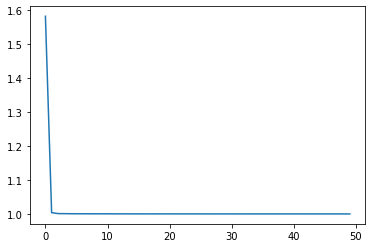

In [31]:
import random
a = []
b = []
sum = 0
for i in range(50):
    b.append(i)
    a.append(i)
random.shuffle(b)
for i in b:
    network.convolutionLayer(x_Train_normalized[0].reshape(28,28))
    network.feedforward()
    index = np.argmax(network.result)
    if(index==y_train_label[0]):
        sum+=1     
    network.backpropagation(y_TrainOneHot[0],0.25)
print(sum,"/50")
plt.plot(a,network.loss)
network.loss.clear()
    

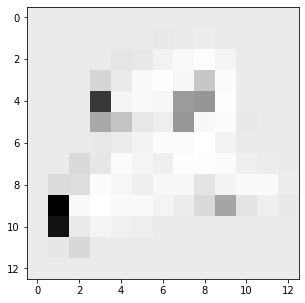

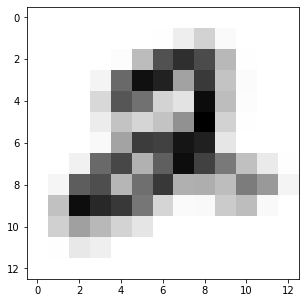

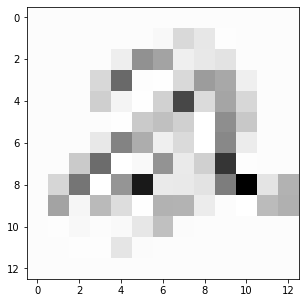

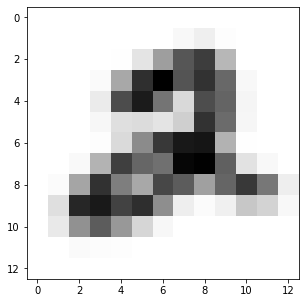

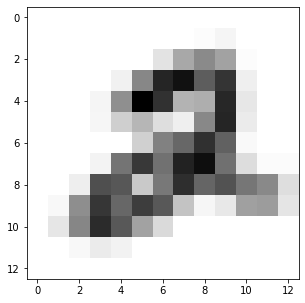

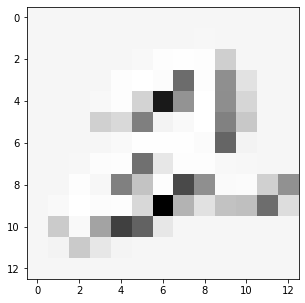

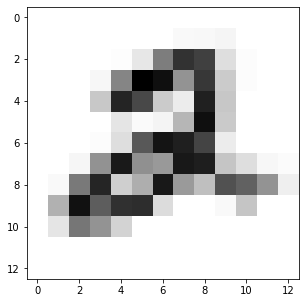

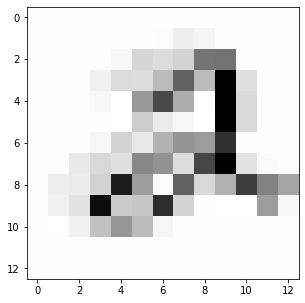

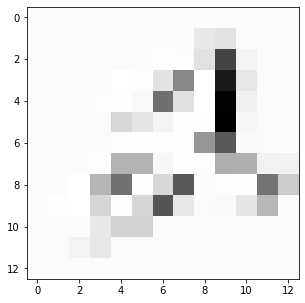

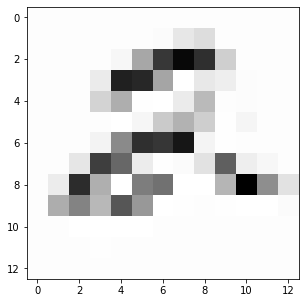

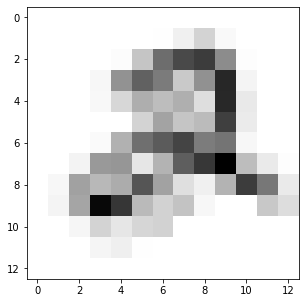

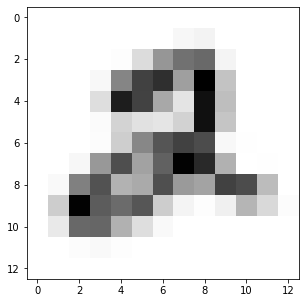

[[ -1981.46388046 -17230.25749729  19011.24150349]
 [  1612.61379066   2479.60975031  19578.07111971]
 [  8092.08672148   1498.50468476  15411.42525923]]
[[476941.32922917 332691.49526461 215255.05730281]
 [425495.86598171 335729.99079897 286284.00074916]
 [469506.87266594 443143.27132699 348472.47961392]]
[[-187422.80102944 -154823.72940162  -89960.45335825]
 [-133181.1686726  -152453.36565433 -100816.33867654]
 [ -23703.79410492 -133661.48131313 -198460.08574466]]
[[196321.99359046 190069.02984457 189352.91344739]
 [295577.48814198 294604.74098876 240710.16388111]
 [305031.59897192 296937.27838988 258313.05495619]]
[[417301.45857863 315107.69794997 286241.49897844]
 [228318.68441351 172129.5506218  222098.84861736]
 [ 94057.29460172 123683.63403704 195296.94567966]]
[[ 43635.82255367 -25203.78600469 -49391.20546922]
 [ 68918.32649211   6202.84202627 -20409.97137387]
 [ 74318.8429857   24418.42255982   2093.89294104]]
[[188198.22567849 179427.82352651 180425.41051774]
 [330804.7242728

In [110]:
network.convolutionLayer(x_Train_normalized[5].reshape(28,28))
network.feedforward()
index = np.argmax(network.result)
if(index==y_train_label[5]):
    sum+=1     
for j in range(12):
    plot_image(network.data_pooling[1][j]*225)
network.backpropagation(y_TrainOneHot[5],0.25)
network.loss.clear()

In [75]:
network.loss.clear()

[[-3.69090766 -0.56950378  0.98206328]
 [ 0.78147027  1.99307003  6.25586297]
 [16.72905081 16.2307724  17.73419387]]
[[102.39624773 115.28409056 122.07778525]
 [123.7568198  124.40148098 116.22370216]
 [ 91.19235309  97.34761531  87.72851834]]
[[-36.14624086 -34.94162137 -19.89356748]
 [ -7.66014708  -1.92980343  -3.72347938]
 [ 30.50108627  -0.91751379 -42.88053812]]
[[-15.27643333  -5.06628613  -8.64892399]
 [-17.75088781  -7.55769133 -17.40905182]
 [-57.6223095  -22.16075348 -21.19477963]]
[[-16.42696752 -29.437555   -42.03649172]
 [-15.78615171 -19.83151429 -22.54002552]
 [  1.52013337  -0.16132526  -4.00507932]]
[[ 69.55806285  32.34800977 -10.1696623 ]
 [ 35.5932891    1.20398943 -34.53123898]
 [-43.82089202 -59.10271765 -69.86249267]]
[[139.7669848  148.98975397 122.26236907]
 [198.26175018 188.45913584 124.92234659]
 [ 94.64377571  79.9415937   57.856881  ]]
[[ -4.7421282  -35.9032824  -79.26173979]
 [ 23.10721461   4.68599926 -34.31078928]
 [ 11.52507514   1.00021823 -12.3478

C:\Users\user\AppData\Local\Temp/ipykernel_35676/865912260.py:34: RuntimeWarning: overflow encountered in square
  self.loss.append(np.sum(np.square(self.result-correction)))
C:\Users\user\AppData\Local\Temp/ipykernel_35676/865912260.py:39: RuntimeWarning: overflow encountered in matmul
  C0_deri = np.matmul(self.weight[i].T,sigmoid)
C:\Users\user\AppData\Local\Temp/ipykernel_35676/865912260.py:39: RuntimeWarning: invalid value encountered in matmul
  C0_deri = np.matmul(self.weight[i].T,sigmoid)
C:\Users\user\AppData\Local\Temp/ipykernel_35676/865912260.py:64: RuntimeWarning: invalid value encountered in multiply
  C0_F = C0_deri*ReLU_deri(self.data_convol_z[position])
C:\Users\user\AppData\Local\Temp/ipykernel_35676/865912260.py:117: RuntimeWarning: invalid value encountered in matmul
  b = np.matmul(rotate,b)


[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


C:\Users\user\AppData\Local\Temp/ipykernel_35676/865912260.py:109: RuntimeWarning: overflow encountered in double_scalars
  sum_ += np.dot(a[i+k][j:j+len(b[k])],b[k])


[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[nan nan nan]
 [nan nan nan]
 [na

3 /50
[nan nan nan nan nan nan nan nan nan nan]


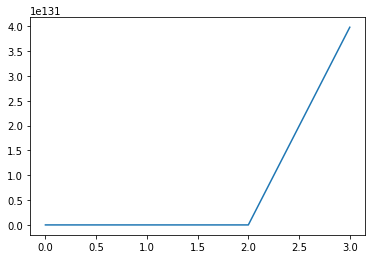

In [125]:
sum=0
a = []
for i in range(20):
    a.append(i)
    network.convolutionLayer(x_Train_normalized[0].reshape(28,28))
    network.feedforward()
    index = np.argmax(network.result)
    if(index==y_train_label[0]):
        sum+=1     
    network.backpropagation(y_TrainOneHot[0],2)
print(sum,"/50")
print(network.result)
plt.plot(a,network.loss)
network.loss.clear()

In [6]:
a = [[0,-1,2,3,4]
    ,[1,2,1,2,1]
    ,[1,2,2,2,2]
    ,[1,1,1,1,2]
    ,[1,2,3,4,5]]
b = [[1,2,3]
    ,[1,2,3]
    ,[1,2,3]]
print(convolute(a,b))
# y = A.T((GgG.T)hadamard(B.TdB))A
BT = np.array([[1,0,-1,0]
             ,[0,1,1,0]
             ,[0,-1,1,0]
             ,[0,-1,0,1]])
G = np.array([[1,0]
             ,[0.5,0.5]
             ,[0.5,-0.5]
             ,[0,1]])
AT = np.array([[1,1,1,0]
             ,[0,1,-1,0]
             ,[0,1,1,1]])
a.reshape(25)
b.reshape(9)

[[23 34 40]
 [25 28 29]
 [31 38 47]]
[[ 1  0  0  0]
 [ 0  1 -1 -1]
 [-1  1  1  0]
 [ 0  0  0  1]]
